In [35]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import re

# Exploratory Data Analysis
### Import Data

In [36]:
job_level_data = pd.read_excel("../data/JobLevelData.xlsx")
job_level_data

,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN
...,...,...,...,...,...
2235,Net Software Architect and Team Project Lead,Manager,NaN,NaN,NaN
2236,Solutions Architect & Technical Lead,Manager,Individual Contributor/Staff,NaN,NaN
2237,"Manager, Salesforcecom Administration and Rele...",Manager,NaN,NaN,NaN
2238,Innovation Automation Architect,Manager,NaN,NaN,NaN


### Handling Missing Data

Let's identify rows where all target columns are NaN, meaning no label is assigned to the position title.

Upon analysis, there are 10 rows without labels, representing only 0.4% of the data. Since this is a very small percentage, several actions could be taken to handle these rows:

- **Manual Labeling**. Given the small number of entries, it might be possible to ask the data provider or client to label them manually. However, for now we don't have direct communication with the client and also lack sufficient knowledge of the data's context to label them accurately ourselves.
- **Data Imputation**. There are several possible variants of imputation: 

    -  **Fill with default values, e.g. "Unknown"**. Not good approach, as introducing a new class may confuse the model and reduce the quality of predictions.
    - **Predictive Imputation**. Might be an overkill for this size of data. 

- **Removing the rows with missing data**. Removing NaN rows may be a reasonable solution, as it would likely have little impact on model performance.

In [37]:
nan_rows = job_level_data[job_level_data.drop(columns=['Title']).isna().all(axis=1)]
print(f"Percentage of not labeled data: {len(nan_rows) / len(job_level_data) * 100}")
nan_rows

Percentage of not labeled data: 0.4464285714285714


,Title,Column 1,Column 2,Column 3,Column 4
29,CINO,NaN,NaN,NaN,NaN
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
829,Release of Information Tech II,NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN
1406,"Global People Systems, Processes and Informati...",NaN,NaN,NaN,NaN
1713,Supplier Quality Engineer,NaN,NaN,NaN,NaN
1785,RC Environmental and Cyber Specialized Subscri...,NaN,NaN,NaN,NaN
2182,Senior Independedirector and Chair of the Cust...,NaN,NaN,NaN,NaN


It was decided to remove the rows with missing data.

In [38]:
job_level_data.drop(nan_rows.index, inplace=True)

### Merging Label Columns into a List

To simplify the manipulation of label data and make it suitable for model input, we need to combine the values from multiple columns into a single list.

In [39]:
job_level_data["Label"] = job_level_data.drop(columns=["Title"]).values.tolist()
job_level_data.drop(columns=["Column 1", "Column 2", "Column 3", "Column 4"], inplace=True)


def remove_nans_from_array(list):
    return [label for label in list if not pd.isna(label)]


job_level_data["Label"] = job_level_data["Label"].apply(remove_nans_from_array)
job_level_data["Label"] = job_level_data["Label"].apply(lambda labels: sorted(labels))

job_level_data

,Title,Label
0,Vice President / Director of Systems Engineering,[Vice President]
1,Systems Engineer; Systems Architect,"[Individual Contributor/Staff, Manager]"
2,"Executive Director, Global IT Infrastructure /...","[Chief Officer, Director]"
3,CTO/Executive Director of Technology Services,"[Chief Officer, Director]"
4,"Vice President, CIO",[Vice President]
...,...,...
2235,Net Software Architect and Team Project Lead,[Manager]
2236,Solutions Architect & Technical Lead,"[Individual Contributor/Staff, Manager]"
2237,"Manager, Salesforcecom Administration and Rele...",[Manager]
2238,Innovation Automation Architect,[Manager]


### Text Preprocessing
- Removing punctiation and any special characters
- Lowercasing the text as the model is not case-sensitive
- Normalizing whitespaces

In [40]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


job_level_data["Title"] = job_level_data["Title"].apply(preprocess_text)
job_level_data.head()

,Title,Label
0,Vice President Director of Systems Engineering,[Vice President]
1,Systems Engineer Systems Architect,"[Individual Contributor/Staff, Manager]"
2,Executive Director Global IT Infrastructure Ch...,"[Chief Officer, Director]"
3,CTO Executive Director of Technology Services,"[Chief Officer, Director]"
4,Vice President CIO,[Vice President]


As BERT tokenizer might separate acronyms, it is highly beneficial to expand them to their full form where possible. 

In [41]:
acronyms_dict = {
    "ceo": "Chief Executive Officer",
    "cfo": "Chief Financial Officer",
    "cto": "Chief Technology Officer",
    "vp": "Vice President",
    "hr": "Human Resources",
    "chro": "Chief Human Resources Officer",
    "cio": "Chief Information Officer",
    "ciso": "Chief Information Security Officer",
    "clo": "Chief Legal Officer",
    "cmo": "Chief Marketing Officer",
    "coo": "Chief Operating Officer",
    "cino": "Chief Innovation Officer",
    "cpo": "Chief Product Officer",
    "cro": "Chief Revenue Officer",
    "evp": "Executive Vice President",
    "svp": "Senior Vice President",
    "it": "Informational Technology"
}


def expand_acronyms(text):
    words = text.split()
    expanded_words = [acronyms_dict.get(word.lower(), word) for word in words]
    return ' '.join(expanded_words)


job_level_data["Title"] = job_level_data["Title"].apply(expand_acronyms)
job_level_data.head()

,Title,Label
0,Vice President Director of Systems Engineering,[Vice President]
1,Systems Engineer Systems Architect,"[Individual Contributor/Staff, Manager]"
2,Executive Director Global Informational Techno...,"[Chief Officer, Director]"
3,Chief Technology Officer Executive Director of...,"[Chief Officer, Director]"
4,Vice President Chief Information Officer,[Vice President]


We do not perform any other preprocessing steps, such as stemming or lemmatization, as the BERT model is designed to understand textual data in context.

### Distribution of Labels

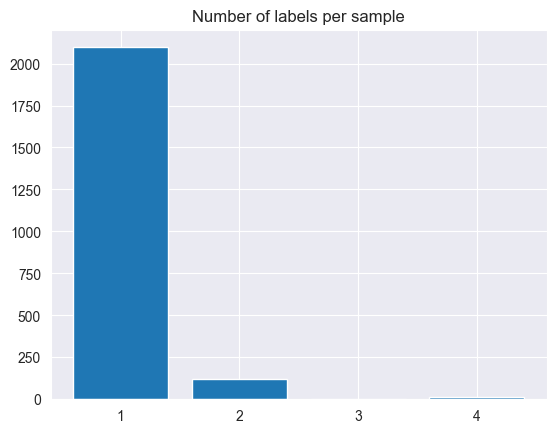

In [42]:
sum_of_labels = job_level_data["Label"].apply(len).value_counts()

fig, ax = plt.subplots()
plt.bar(sum_of_labels.index, sum_of_labels.values)
plt.title('Number of labels per sample')
plt.xticks(sum_of_labels.index)  # Ensure x-axis ticks match the sum values

plt.show()

As the majority of the samples have only one label assigned, it can be concluded that the data is sparse.

In [43]:
avg_labels_count_per_sample = job_level_data["Label"].apply(len).mean()
avg_labels_count_per_sample

np.float64(1.0699551569506727)

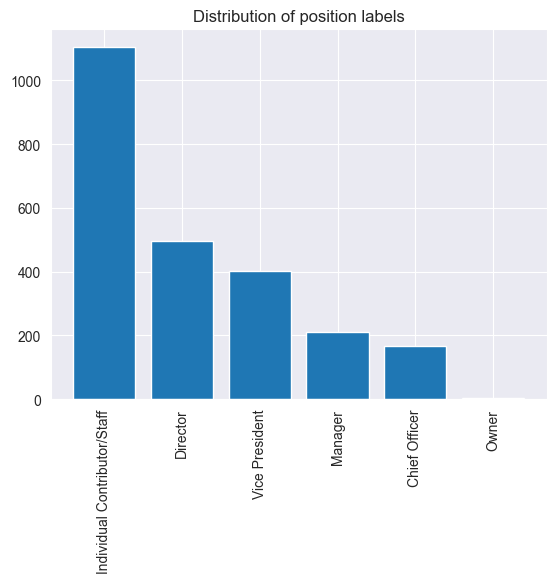

In [44]:
labels_list = [label for labels_list in job_level_data["Label"] for label in labels_list]
labels_count = sorted(Counter(labels_list).items(), key=lambda x: x[1], reverse=True)
labels_count_keys, labels_count_values = zip(*labels_count)

plt.bar(labels_count_keys, labels_count_values)
plt.title('Distribution of position labels')
plt.xticks(rotation=90) 

plt.show()

It can be observed from the distribution, the data is highly imbalanced, with "Owner" label being highly under respresented. This imbalance requires further attention during model training and evaluation.

### "Owner" Label Exploration

In [45]:
owner_label_entries = job_level_data[job_level_data["Label"].apply(lambda labels: "Owner" in labels)]
owner_label_entries

,Title,Label
22,CoFounder Chief Technology Officer,"[Chief Officer, Owner]"
119,Chief Operating Officer Co Founder,"[Chief Officer, Owner]"
1222,Co Owner Vice President and General Counsel,[Owner]
1933,Founder Chief Operating Officer,"[Chief Officer, Owner]"


As can be observed from the data, there is only 4 entries labeled as "Owner". This is insufficient for effectively training a machine learning model, especially for creating an adequate train-test split.

To address this, we can check if we can assign the "Owner" label based on whether the title contains keywords like "Owner" or "Founder" during the model inference.  

In [46]:
job_level_data[job_level_data["Title"].apply(lambda title: "Owner" in title)]

,Title,Label
30,Owner Data Architect,"[Chief Officer, Manager]"
896,Senior Manager Product Owner Wireless Expansio...,"[Director, Manager, Vice President]"
998,Co Owner Marketing Manager,"[Chief Officer, Manager]"
1054,Practice Owner,[Individual Contributor/Staff]
1222,Co Owner Vice President and General Counsel,[Owner]
1481,In App Learning Owner Software,[Individual Contributor/Staff]
1566,Owner Services Coordinator,[Individual Contributor/Staff]
1632,Owner Franchisee,[Chief Officer]
1828,Senior Software Consultant Product Owner,[Individual Contributor/Staff]
1847,Product Owner Digital Data and IS Direction,[Manager]


Inspecting data above, it was found that not all titles containing the words "Owner" or "Founder" are labeled as "Owner." This suggests that making a decision to hard-code labelling of this category would be unreliable. 

In conclusion, the "Owner" label may not be predictable given the data currently available. As there are usually only a few owners of the company, it would be better to label the data manually on top of models prediction. Therefore, we will remove the entries with the "Owner" label.

In [47]:
job_level_data.drop(owner_label_entries.index, inplace=True)

### "Manager" Label Exploration
The baseline model yields a high number of false negatives for the "Manager" label, failing to predict it correctly. Let's explore the data to understand why this is happening .

In [48]:
manager_label_entries = job_level_data[job_level_data["Label"].apply(lambda labels: "Manager" in labels)]
manager_label_entries

,Title,Label
1,Systems Engineer Systems Architect,"[Individual Contributor/Staff, Manager]"
14,Lead Software Engineer Technical Team Lead,"[Individual Contributor/Staff, Manager]"
30,Owner Data Architect,"[Chief Officer, Manager]"
32,Chief Executive Officer Solution Architect,"[Chief Officer, Manager]"
34,Cloud Architect DevOps Engineer Tech Lead,"[Individual Contributor/Staff, Manager]"
...,...,...
2234,Solution Architect Technical Account Manager,[Manager]
2235,Net Software Architect and Team Project Lead,[Manager]
2236,Solutions Architect Technical Lead,"[Individual Contributor/Staff, Manager]"
2237,Manager Salesforcecom Administration and Relea...,[Manager]


### "Chief Officer" Label Exploration
The baseline model yields a high number of false negatives for the "Chief Officer" label, failing to predict it correctly. Let's explore the data to understand why this is happening.

In [49]:
manager_label_entries = job_level_data[job_level_data["Label"].apply(lambda labels: "Chief Officer" in labels)]
manager_label_entries.sample(10)

,Title,Label
49,Chief Information Officer Head of Product Engi...,[Chief Officer]
112,Corporate Informational Technology Director Ch...,"[Chief Officer, Director]"
26,Founder Chief Executive Officer and Chief Tech...,[Chief Officer]
984,Chief Marketing Digital I D and Quality Officer,[Chief Officer]
59,Vice President of Information Technology Chief...,[Chief Officer]
53,Chief Technology Officer Head of Search,"[Chief Officer, Director]"
985,Chief Information Officer Ocio and Information...,[Chief Officer]
453,Chief Product Officer Product Eng Technology Data,[Chief Officer]
1991,Chief Sales Officer Consumer Grade UX Applicat...,[Chief Officer]
529,Co President and Chief Operating Officer,[Chief Officer]


The data shows that titles that contain "Chief"/"Chief Officer" word are not always labeled as "Chief Officer", minimising the difference in data between the classes. 

In [50]:
filtered_data = job_level_data[
    job_level_data["Title"].str.contains("Chief") & 
    ~job_level_data["Label"].apply(lambda labels: "Chief Officer" in labels)
]

selected_rows = job_level_data.loc[filtered_data.index]
selected_rows.head()

,Title,Label
4,Vice President Chief Information Officer,[Vice President]
12,Chief Information Officer and Senior Vice Pres...,[Vice President]
16,Vice President of Information Technology and C...,[Vice President]
18,Chief Informatics Officer,[Vice President]
56,General Manager Technology Chief Information O...,[Vice President]


### Label One-Hot Encoding

In [51]:
mlb = MultiLabelBinarizer()
one_hot_encoded_labels = mlb.fit_transform(job_level_data["Label"])
one_hot_df = pd.DataFrame(one_hot_encoded_labels, columns=mlb.classes_)
job_level_data["Label"] = one_hot_df.values.tolist()

classes_labels = mlb.classes_
print(classes_labels)

job_level_data

['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Vice President']


,Title,Label
0,Vice President Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer Systems Architect,"[0, 0, 1, 1, 0]"
2,Executive Director Global Informational Techno...,"[1, 1, 0, 0, 0]"
3,Chief Technology Officer Executive Director of...,"[1, 1, 0, 0, 0]"
4,Vice President Chief Information Officer,"[0, 0, 0, 0, 1]"
...,...,...
2235,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2236,Solutions Architect Technical Lead,"[0, 0, 1, 1, 0]"
2237,Manager Salesforcecom Administration and Relea...,"[0, 0, 0, 1, 0]"
2238,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


In [52]:
one_hot_df

,Chief Officer,Director,Individual Contributor/Staff,Manager,Vice President
0,0,0,0,0,1
1,0,0,1,1,0
2,1,1,0,0,0
3,1,1,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
2221,0,0,0,1,0
2222,0,0,1,1,0
2223,0,0,0,1,0
2224,0,0,0,1,0


In [53]:
# update labels list and count for further usage
labels_count = one_hot_df.sum()
labels_count = labels_count.to_dict()
labels_count

{'Chief Officer': 163,
 'Director': 497,
 'Individual Contributor/Staff': 1105,
 'Manager': 211,
 'Vice President': 403}

### Correlation Matrix
The following observations can be made from the correlation matrix:
- **Mostly negative or zero correlations**. This indicates that most roles do not overlap and positions tend to be rather mutually exclusive.
- **Clear Hierarchy**. There is a noticeable negative correlation between lower-level roles such as "Individual Contributor/Staff" and higher-level positions like "Director"(-0.5), "Vice President"(-0.44) and Chief Officer(-0.27). This makes sense because it is unlikely for someone to be classified as both an individual contributor and a senior executive at the same time. 

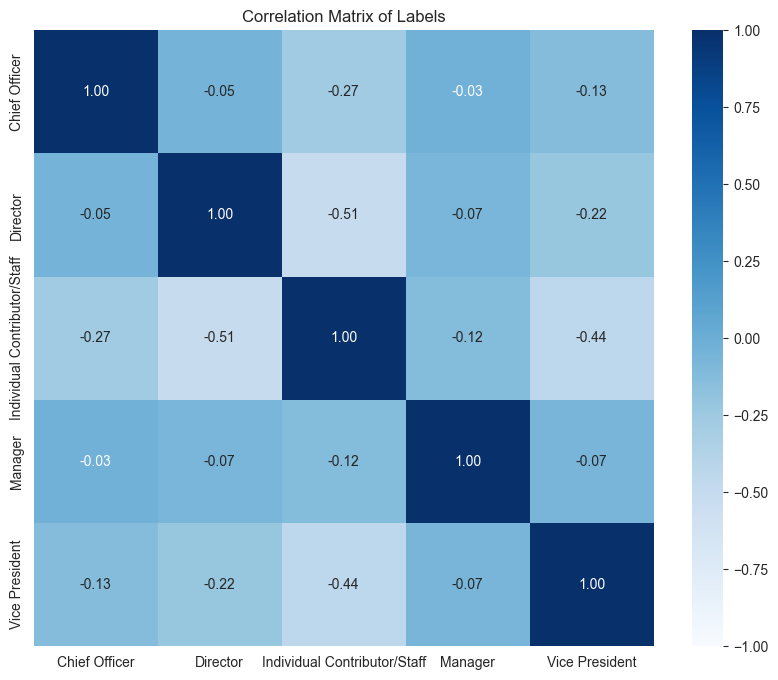

In [54]:
correlation_matrix = one_hot_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Labels')
plt.show()

### Tokenization
Uncased BERT model will be used to tokenize the data (wordpiece algorithm). The uncased model was chosen as it is avaliable in a smaller size, which is more suitable for this task.

In [55]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-6_H-256_A-4')

In [56]:
def split_text(text):
    text = text.lower()
    return tokenizer.tokenize(text)

max_len = job_level_data["Title"].apply(split_text).apply(len).max()
print("Maximum lengths of tokenized sentence: ", max_len)

Maximum lengths of tokenized sentence:  19


## Save The Preprocessed Data

In [57]:
 job_level_data.to_csv("../data/JobLevelData_preproc.csv", index=False)